# Battle of the Neighborhood

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will find the best neighborhoods to open a theater in Chicago.

Since there are theaters throughout the city, the goal is to find the neighboor with a high popluation density, low amount of theaters, and use clustering to find Neighborhoods that are similar to the neighborhoods that already have movie theaters.

A list of top neighboors will be provided. Allowing them to see pros and cons from each neighborhood to decide where to open a new theater.

## Data <a name="data"></a>

Looking at the problem the key data need:


* The popluation of Neighborhoods
* The amount of theaters in the Neighborhoods
* The amount of attracts in the Neighborhoods
* The Area of the Neighborhood
* The Popluation Density of a Neighborhood


### Grabbing the Popluation and Area per Neighborhood

This is the libraries used for the project.

In [ ]:
import numpy as np
import pandas as pd

import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium

This Section is web scraping the neighborhoods, Popluation, Area, and Popluation Density.

In [ ]:
url = "https://en.wikipedia.org/wiki/Community_areas_in_Chicago"
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, "html5lib")

The newest population by neighborhood that was found was 2017. This data will be used for the population and population density.

In [ ]:
Neighborhood_data = pd.DataFrame(columns=['Number', 'Name', '2017 Population', 'Area (Sq mi.)', 'Area (km^2)', '2017 Population Density (Sq mi.)', '2017 Population Density (km^2)'])

tables = soup.find("table")
for rows in tables.findAll("tr"):
  col = rows
  col = col.text.split("\n\n")
  num = col[0].replace('\n', '')
  name = col[1]
  pop = col[2]
  a1 = col[3]
  a2 = col[4]
  pd1 = col[5]
  pd2 = col[6].replace('\n', '')
  
  Neighborhood_data = Neighborhood_data.append({"Number":num, "Name":name, "2017 Population":pop, "Area (Sq mi.)":a1, "Area (km^2)":a2, "2017 Population Density (Sq mi.)":pd1, "2017 Population Density (km^2)":pd2}, ignore_index=True)


Cleaning up the DataFrame up.

In [ ]:
Neighborhood_data = Neighborhood_data[1:-1]
Neighborhood_data

,Number,Name,2017 Population,Area (Sq mi.),Area (km^2),2017 Population Density (Sq mi.),2017 Population Density (km^2)
1,01,Rogers Park,"55,062",1.84,4.77,"29,925.00","11,554.11"
2,02,West Ridge,"76,215",3.53,9.14,"21,590.65","8,336.20"
3,03,Uptown,"57,973",2.32,6.01,"24,988.36","9,648.06"
4,04,Lincoln Square,"41,715",2.56,6.63,"16,294.92","6,291.50"
5,05,North Center,"35,789",2.05,5.31,"17,458.05","6,740.59"
...,...,...,...,...,...,...,...
73,73,Washington Heights,"27,453",2.86,7.41,"9,598.95","3,706.18"
74,74,Mount Greenwood,"19,277",2.71,7.02,"7,113.28","2,746.45"
75,75,Morgan Park,"22,394",3.30,8.55,"6,786.06","2,620.11"
76,76,O'Hare,"12,377",13.34,34.55,927.81,358.23


### Latitudes and Longitudes

This section is getting the latitudes and longitudes for each Neighborhood.

Using a excel has the zip codes latitude and longitude and this section puts it in a DataFrame.

In [ ]:
lat_lng_data = pd.read_excel("us-zip-code-latitude-and-longitude.xlsx")
lat_lng_data = lat_lng_data.drop(labels=['City','State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1)
lat_lng_data

,Zip,Latitude,Longitude
0,60415,41.702482,-87.77869
1,60668,41.811929,-87.68732
2,60646,41.995331,-87.76010
3,60654,41.888627,-87.63538
4,60647,41.921126,-87.70085
...,...,...,...
87,60411,41.511307,-87.61010
88,60678,41.811929,-87.68732
89,60671,41.811929,-87.68732
90,60681,41.811929,-87.68732


This web scraps the website to get the zip code for each neighborhood.

In [ ]:
url ="https://www.chicagotribune.com/chi-community-areas-htmlstory.html"
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, "html5lib")
tables = soup.find_all("table")

zip_code = pd.DataFrame(columns=['Zip', 'Name'])
i = 0
for table in tables:
  if i == 3:
    for rows in table.findAll("tr"):
      col = rows.find_all("td")
      zipc = col[0].text
      location = []
      location = col[1].text.split(", ")
      if len(location) == 1:
        zip_code = zip_code.append({"Zip":int(zipc), "Name":str(location[0])}, ignore_index=True)

      if len(location) > 1:
        for i in range(len(location)):
          zip_code = zip_code.append({"Zip":int(zipc), "Name":str(location[i])}, ignore_index=True)

  i +=1 

zip_code.head()

,Zip,Name
0,60601,Loop
1,60602,Loop
2,60603,Loop
3,60604,Loop
4,60605,Loop


This section merge the two DataFrames on the zip code column. It then drops the zip code column. Instead of having mutiple latitudes and longitudes the DataFrame is groupby and average to get one latitude and longitude for each neighborhood.

In [ ]:
zip_code_neigh = pd.merge(zip_code, lat_lng_data, on="Zip")
zip_code_neigh = zip_code_neigh.drop(['Zip'], axis=1)
n_lat_lng = zip_code_neigh.groupby("Name").mean().reset_index()
n_lat_lng = n_lat_lng.sort_values(by=['Name'], ascending=True)
n_lat_lng.head()

,Name,Latitude,Longitude
0,Albany Park,41.971329,-87.730625
1,Archer Heights,41.809299,-87.710500
2,Armour Square,41.830842,-87.642040
3,Ashburn,41.744600,-87.711880
4,Auburn Gresham,41.740483,-87.652820


This is cleaning up the Neighborhood data and getting a new DataFrame that will be used to merge the Chicago neighborhoods and their latitudes and longitudes.

In [ ]:
Neighborhood_data['Name'] = Neighborhood_data['Name'].str.replace('(The)','')
Neighborhood_data['Name'] = Neighborhood_data['Name'].str.replace("11",'')
Neighborhood_data['Name'] = Neighborhood_data['Name'].str.strip("[]()")  	
Neighborhood_data['Name'] = Neighborhood_data['Name'].str.replace("Beverly Hills",'Beverly')
Neighborhood_data['Upper'] = Neighborhood_data['Name'].str.upper()
Neighborhood_data['Upper'] = Neighborhood_data['Upper'].str.replace(' ','')
Neighborhood_data['Upper'] = Neighborhood_data['Upper'].str.replace('BEVERLYHILLS','BEVERLY')
merge1 = Neighborhood_data.drop(['2017 Population', 'Area (Sq mi.)', 'Area (km^2)', '2017 Population Density (Sq mi.)', '2017 Population Density (km^2)'], axis=1)
merge1

,Number,Name,Upper
1,01,Rogers Park,ROGERSPARK
2,02,West Ridge,WESTRIDGE
3,03,Uptown,UPTOWN
4,04,Lincoln Square,LINCOLNSQUARE
5,05,North Center,NORTHCENTER
...,...,...,...
73,73,Washington Heights,WASHINGTONHEIGHTS
74,74,Mount Greenwood,MOUNTGREENWOOD
75,75,Morgan Park,MORGANPARK
76,76,O'Hare,O'HARE


This section is cleaning up the latitude and longitude DataFrame and creating another DataFrame for merging Neighborhood and latitude and longitude. The Riverdale information is added, because it was missing.

In [ ]:
n_lat_lng['Upper'] = n_lat_lng['Name'].str.upper()
n_lat_lng['Upper'] = n_lat_lng['Upper'].str.replace(' ','')
n_lat_lng['Upper'] = n_lat_lng['Upper'].str.replace('(PILSEN)','').str.strip("[]()")
merge2 = n_lat_lng.drop('Name', axis=1)
merge2 = merge2.append({'Latitude':41.66, 'Longitude':-87.61, 'Upper':'RIVERDALE'}, ignore_index=True)
merge2.sort_values(by='Upper').head()

,Latitude,Longitude,Upper
0,41.971329,-87.730625,ALBANYPARK
1,41.809299,-87.710500,ARCHERHEIGHTS
2,41.830842,-87.642040,ARMOURSQUARE
3,41.744600,-87.711880,ASHBURN
4,41.740483,-87.652820,AUBURNGRESHAM


Finally merging the two and dropping entries in the DataFrame that don't have neighborhoods. Now we have data to use for FourSquare.

In [ ]:
result = pd.merge(merge1, merge2, how="left", on=["Upper"]).dropna()
result = result.drop(['Name','Upper'],axis=1)
num_name = Neighborhood_data[['Number', 'Name']]
result = result.groupby('Number').mean()
Neigh_lat_lng = pd.merge(num_name, result, how="left", on=["Number"])
Neigh_lat_lng['Number'] = Neigh_lat_lng['Number'].astype('int')
Neigh_lat_lng

,Number,Name,Latitude,Longitude
0,1,Rogers Park,42.009731,-87.669380
1,2,West Ridge,42.000169,-87.700060
2,3,Uptown,41.963218,-87.664700
3,4,Lincoln Square,41.972397,-87.684530
4,5,North Center,41.945150,-87.671185
...,...,...,...,...
72,73,Washington Heights,41.710783,-87.645100
73,74,Mount Greenwood,41.696283,-87.699120
74,75,Morgan Park,41.696358,-87.679525
75,76,O'Hare,41.975080,-87.816300


Mapping out the neighbors of Chicago.

In [ ]:
map_neighborhoods = folium.Map(location=[41.881832, -87.623177], zoom_start=10)

x = np.arange(77)
ys = [i + x + (i*x)**2 for i in range(77)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, number in zip(Neigh_lat_lng['Latitude'], Neigh_lat_lng['Longitude'], Neigh_lat_lng['Name'], Neigh_lat_lng['Number']):
    label = folium.Popup(str(poi) + ' Number ' + str(number), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[number-1],
        fill=True,
        fill_color=rainbow[number-1],
        fill_opacity=0.7).add_to(map_neighborhoods)
       
map_neighborhoods

In [ ]:
Neigh_lat_lng = Neigh_lat_lng.drop('Number',axis=1)

### Foursquare


##### Getting data from FourSquare

In [ ]:
CLIENT_ID = '' 
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100 
radius = 500

A function the will get the information from FourSquare and store it into a DataFrame.

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #results = requests.get(url).json()["response"][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
Venue_data = getNearbyVenues(names=Neigh_lat_lng['Name'], latitudes=Neigh_lat_lng['Latitude'], longitudes=Neigh_lat_lng['Longitude'])
Venue_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.009731,-87.66938,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,Rogers Park,42.009731,-87.66938,The Common Cup,42.007797,-87.667901,Coffee Shop
2,Rogers Park,42.009731,-87.66938,Smack Dab,42.009291,-87.666201,Bakery
3,Rogers Park,42.009731,-87.66938,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market
4,Rogers Park,42.009731,-87.66938,Rogers Park Social,42.007360,-87.666265,Bar
...,...,...,...,...,...,...,...
1314,Edgewater,41.981906,-87.66660,Mr. & Mrs. Digz,41.985466,-87.669493,Boutique
1315,Edgewater,41.981906,-87.66660,BMO Harris Bank,41.985693,-87.669302,Bank
1316,Edgewater,41.981906,-87.66660,Hollywood Spirits,41.985439,-87.663277,Liquor Store
1317,Edgewater,41.981906,-87.66660,On the Rocks Gems Jewelry & More,41.985835,-87.669056,Jewelry Store


#### Cleaning up the data

In [ ]:
Venue_data.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Loop,66,66,66,66,66,66
Albany Park,23,23,23,23,23,23
Archer Heights,14,14,14,14,14,14
Armour Square,24,24,24,24,24,24
Ashburn,4,4,4,4,4,4
...,...,...,...,...,...,...
West Lawn,8,8,8,8,8,8
West Pullman,9,9,9,9,9,9
West Ridge,17,17,17,17,17,17


This is creating a onehot encoder to be used for clustering.

In [ ]:
Neighborhood_onehot = pd.get_dummies(Venue_data[['Venue Category']], prefix="", prefix_sep="")
Neighborhood_onehot['Neighborhood'] = Venue_data['Neighborhood']
fixed_columns = [Neighborhood_onehot.columns[-1]] + list(Neighborhood_onehot.columns[:-1])
Neighborhood_onehot = Neighborhood_onehot[fixed_columns]
pd.set_option('display.max_columns', None) 
Neighborhood_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Café,Camera Store,Candy Store,Caribbean Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pop-Up Shop,Pub,Public Art,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rogers Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

This is grouping and getting all the data with the neighborhoods with movie theaters. Theaters are added because there isn't away to break the difference between movie theaters and play theaters.

In [ ]:
Neigh_indiemovie_count = Neighborhood_onehot[['Neighborhood', 'Indie Movie Theater']]
Neigh_indiemovie_count = Neigh_indiemovie_count.loc[(Neigh_indiemovie_count['Indie Movie Theater']!=0)]
Neigh_movie_count = Neighborhood_onehot[['Neighborhood', 'Movie Theater']]
Neigh_movie_count = Neigh_movie_count.loc[(Neigh_movie_count['Movie Theater']!=0)]
Neigh_theater_count = Neighborhood_onehot[['Neighborhood', 'Theater']]
Neigh_theater_count = Neigh_theater_count.loc[(Neigh_theater_count['Theater']!=0)]
Neigh_withtheater = Neigh_indiemovie_count.append(Neigh_movie_count, sort=False)
Neigh_withtheater = Neigh_withtheater.append(Neigh_theater_count, sort=False)
Neigh_withtheater = Neigh_withtheater.groupby('Neighborhood').count().reset_index()
Neigh_withtheater

,Neighborhood,Indie Movie Theater,Movie Theater,Theater
0,Loop,0,0,2
1,Belmont Cragin,0,0,1
2,Chatham,0,1,0
3,Edgewater,0,0,1
4,Hyde Park,0,0,1
5,Lake View,1,0,1
6,Near West Side,0,0,1
7,North Center,0,0,1
8,Rogers Park,0,0,3
9,South Lawndale,0,0,1


This is will be used to Cluster the Neighborhoods. Takeing out the movie theater to make sure they are cluster by it. The popluation will be added to have another dimension to cluster the neighborhoods.

In [ ]:
Neigh_cluster = Neighborhood_onehot.drop(['Indie Movie Theater', 'Movie Theater', 'Theater'], axis =1)
Neigh_group = Neigh_cluster.groupby('Neighborhood').mean().reset_index()
N_pop = Neighborhood_data[['Name', '2017 Population','2017 Population Density (Sq mi.)']]
N_pop = N_pop.rename(columns={"Name": "Neighborhood", "2017 Population":'Pop.',"2017 Population Density (Sq mi.)":'PPSM'})
N_pop['Pop.'] = N_pop['Pop.'].str.replace(',','')
N_pop['Pop.'] = N_pop['Pop.'].astype('float')
N_pop['PPSM'] = N_pop['PPSM'].str.replace(',','')
N_pop['PPSM'] = N_pop['PPSM'].astype('float')
Neigh_group_f = pd.merge(Neigh_group, N_pop, how="left", on=["Neighborhood"]).dropna()
Neigh_group_f

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Café,Camera Store,Candy Store,Caribbean Restaurant,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Light Rail Station,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pop-Up Shop,Pub,Public Art,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Snack Place,Soccer Field,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Transportation Service,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Pop.,PPSM
0,Loop,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.00000,0.0,0.015152,0.015152,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.030303,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015152,0.0,0.000000,0.00000,0.0,0.0,0.015152,0.015152,0.000000,0.0,0.0,0.000000,0.015152,0.000,0.0,0.000000,0.000000,0.0,0.0,0.015152,0.136364,0.0,0.0,0.0,0.0,0.0,0.015152,0.015152,0.015152,0.0,0.0,0.0,0.030303,0.0,0.015152,0.000000,0.000000,0.000000,0.0,0.015152,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.015152,0.0,0.015152,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.015152,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015152,0.0,0.0,0.0,0.015152,0.000000,0.0,0.000000,0.030303,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.060606,0.000000,0.000000,0.0,0.000000,0.0,0.030303,0.00

## Methodology <a name="methodology"></a>

This project will first cluster the neighborhoods. Seeing which neighborhoods are similar. From there the clusters with neighborhoods that have movies already in them will be examine. Taking note of all the neighborhoods of the cluster that doesn't have movie theaters.

Next the popluation and population density will be examine. Using the whole neighborhood data set and the selected neighborhoods from the clustering set will be ranked by popluation density.

The top five highest popluation densities per list will be saved into a list.

## Analysis <a name="analysis"></a>

### Clusters

This is creating clusters to group each of the neighborhoods. The next line will add the cluster values into a Dataframe.

In [ ]:
N_data = Neigh_group_f.drop('Neighborhood', axis=1)
kcluster = 4
kmeans = KMeans(n_clusters=kcluster, init='k-means++', n_init=15).fit(N_data)

In [ ]:
Neigh_f = Neigh_group_f[['Neighborhood', 'Pop.', 'PPSM']]
Neigh_f.insert(0, 'Cluster Values', kmeans.labels_)
Neigh_f

,Cluster Values,Neighborhood,Pop.,PPSM
0,0,Loop,35880.0,21745.45
1,1,Albany Park,51992.0,27079.17
2,2,Archer Heights,13142.0,6538.31
3,2,Armour Square,13455.0,13455.00
4,0,Ashburn,43792.0,9010.70
...,...,...,...,...
71,0,West Lawn,33108.0,11223.05
72,0,West Pullman,27742.0,7792.70
73,3,West Ridge,76215.0,21590.65
74,3,West Town,84502.0,18450.22


In [ ]:
Neigh_f['Theater'] = Neigh_f['Neighborhood'].isin(Neigh_withtheater['Neighborhood'])
cluser_values = Neigh_f.loc[(Neigh_f['Theater']==True)]
cluser_values.groupby('Cluster Values').count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Pop.,PPSM,Theater
Cluster Values,,,,
0,4,4,4,4
1,4,4,4,4
3,3,3,3,3


### Cluster Map

This is mapping the clusters on a map of Chicago.

In [ ]:
NC_map = Neigh_f[['Neighborhood', 'Cluster Values']]
NC_map = NC_map.rename(columns={"Neighborhood": 'Name'})
cluster_map = pd.merge(NC_map, Neigh_lat_lng, how="left", on='Name').dropna()
cluster_map

,Name,Cluster Values,Latitude,Longitude
0,Loop,0,41.878499,-87.632795
1,Albany Park,3,41.971329,-87.730625
2,Archer Heights,1,41.809299,-87.710500
3,Armour Square,1,41.830842,-87.642040
4,Ashburn,0,41.744600,-87.711880
...,...,...,...,...
71,West Lawn,0,41.777482,-87.711550
72,West Pullman,0,41.695933,-87.641240
73,West Ridge,2,42.000169,-87.700060
74,West Town,2,41.900713,-87.685940


In [ ]:
map_clusters = folium.Map(location=[41.881832, -87.623177], zoom_start=10)

x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(cluster_map['Latitude'], cluster_map['Longitude'], cluster_map['Name'], cluster_map['Cluster Values']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### List Grouping

This section is creating four different DataFrames that will be explored in. Since two clusters have the same amount of neighborhoods with movie theaters both clusters will be looked at together and individually. The last DataFrame is of all the neighborhoods that don't have theaters.

This is creating the first DataFrame from cluster 1.

In [ ]:
Cluster1 = Neigh_f.loc[(Neigh_f['Cluster Values']==1)]
Cluster1 = Cluster1.loc[(Cluster1['Theater'] == False)]
Cluster1 = Cluster1.reset_index()
Cluster1 = Cluster1.drop(['index','Theater'],axis=1)
Cluster1

,Cluster Values,Neighborhood,Pop.,PPSM
0,1,Albany Park,51992.0,27079.17
1,1,Chicago Lawn,53098.0,15041.93
2,1,Humboldt Park,56427.0,15674.17
3,1,Irving Park,54606.0,17011.21
4,1,Lincoln Park,67710.0,21427.22
5,1,Portage Park,64307.0,16280.25
6,1,South Shore,50418.0,17207.51


This is creating a DataFrame from Cluster 2.

In [ ]:
Cluster2 = Neigh_f.loc[(Neigh_f['Cluster Values']==2)]
Cluster2 = Cluster2.loc[(Cluster2['Theater'] == False)]
Cluster2 = Cluster2.reset_index()
Cluster2 = Cluster2.drop(['index','Theater'], axis=1)
Cluster2

,Cluster Values,Neighborhood,Pop.,PPSM
0,2,Archer Heights,13142.0,6538.31
1,2,Armour Square,13455.0,13455.00
2,2,Avalon Park,9985.0,7988.00
3,2,Beverly,20822.0,6547.80
4,2,Burnside,2254.0,3695.08
5,2,Calumet Heights,13188.0,7536.00
6,2,Douglas,20781.0,12594.55
7,2,East Garfield Park,19996.0,10360.62
8,2,East Side,23737.0,7965.44
9,2,Edison Park,11605.0,4235.40


This is creating a DataFrame from both cluster 1 and cluster 2.

In [ ]:
both_clusters = pd.concat([Cluster1, Cluster2])
both_clusters = both_clusters.reset_index()
both_clusters = both_clusters.drop('index', axis=1)
both_clusters

,Cluster Values,Neighborhood,Pop.,PPSM
0,1,Albany Park,51992.0,27079.17
1,1,Chicago Lawn,53098.0,15041.93
2,1,Humboldt Park,56427.0,15674.17
3,1,Irving Park,54606.0,17011.21
4,1,Lincoln Park,67710.0,21427.22
5,1,Portage Park,64307.0,16280.25
6,1,South Shore,50418.0,17207.51
7,2,Archer Heights,13142.0,6538.31
8,2,Armour Square,13455.0,13455.00
9,2,Avalon Park,9985.0,7988.00


This is the DataFrame not using all Neighborhoors not having Theaters.

In [ ]:
N_pop['Theater'] = N_pop['Neighborhood'].isin(Neigh_withtheater['Neighborhood'])
N_list = N_pop.loc[(N_pop['Theater'] == False)]
N_list = N_list.reset_index()
N_list = N_list.drop(['index','Theater'], axis=1)
N_list

,Neighborhood,Pop.,PPSM
0,West Ridge,76215.0,21590.65
1,Lincoln Square,41715.0,16294.92
2,Lincoln Park,67710.0,21427.22
3,Near North Side,88893.0,32442.70
4,Edison Park,11605.0,4235.40
...,...,...,...
61,Beverly,20822.0,6547.80
62,Washington Heights,27453.0,9598.95
63,Mount Greenwood,19277.0,7113.28
64,Morgan Park,22394.0,6786.06


This section grabs the top ten key features from the neighborhoods that have theaters.

In [ ]:
Neigh_group_f['Theater'] = Neigh_group_f['Neighborhood'].isin(Neigh_withtheater['Neighborhood'])
theater_features = Neigh_group_f.loc[(Neigh_f['Theater']==True)]
theater_features = theater_features.drop('Theater', axis=1)

In [ ]:
feature_sum = pd.DataFrame(columns=['Venue','Sum'])
for i in theater_features.columns:
  hold1 = i
  hold2 = theater_features[i].sum()
  feature_sum = feature_sum.append({"Venue":hold1, "Sum":hold2}, ignore_index=True)

feature_sum = feature_sum[1:-2]
feature_sum

,Venue,Sum
1,Yoga Studio,0.0407925
2,ATM,0.0454545
3,Accessories Store,0
4,Adult Boutique,0.0196078
5,Airport,0
...,...,...
223,Whisky Bar,0.0255682
224,Wine Bar,0
225,Wine Shop,0.0331439
226,Wings Joint,0


In [ ]:
feature_sum = feature_sum.loc[(feature_sum['Sum']>0)]
feature_sum = feature_sum.sort_values('Sum', ascending=False)
feature_sum_top_ten = feature_sum.head(10)
feature_sum_top_ten

,Venue,Sum
189,Sandwich Place,0.690711
50,Coffee Shop,0.561691
149,Mexican Restaurant,0.517908
175,Pizza Place,0.460357
19,Bar,0.283223
17,Bakery,0.273947
6,American Restaurant,0.250552
42,Café,0.248504
18,Bank,0.235644
46,Chinese Restaurant,0.214377


### Visualization

This is the visualization of the key features that neighborhoods that have movie theater.

<function matplotlib.pyplot.show>

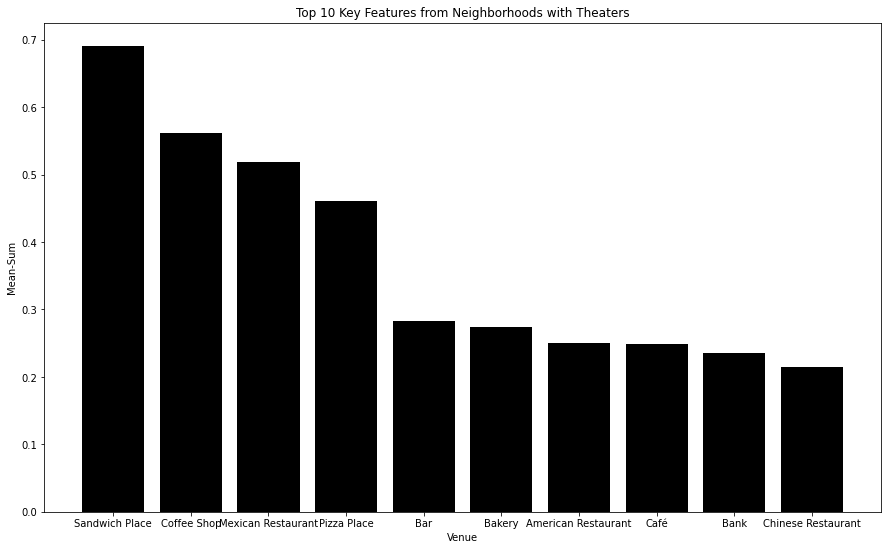

In [ ]:
fig = plt.figure(figsize=(15,9))

plt.bar(feature_sum_top_ten['Venue'], feature_sum_top_ten['Sum'], color='black')
plt.title("Top 10 Key Features from Neighborhoods with Theaters")
plt.xlabel("Venue")
plt.ylabel("Mean-Sum")
plt.show

This is visualizing the top five neighborhoods by popluation and popluation density for each DataFrame.

<function matplotlib.pyplot.show>

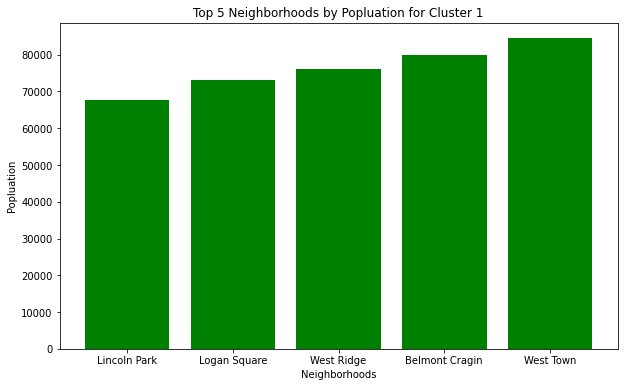

In [ ]:
top5_c1 = Cluster1.sort_values(by=['Pop.'], ascending=True,).head(5)
fig = plt.figure(figsize=(10,6))

plt.bar(top5_c1['Neighborhood'], top5_c1['Pop.'], color='green')
plt.title("Top 5 Neighborhoods by Popluation for Cluster 1")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation")
plt.show

<function matplotlib.pyplot.show>

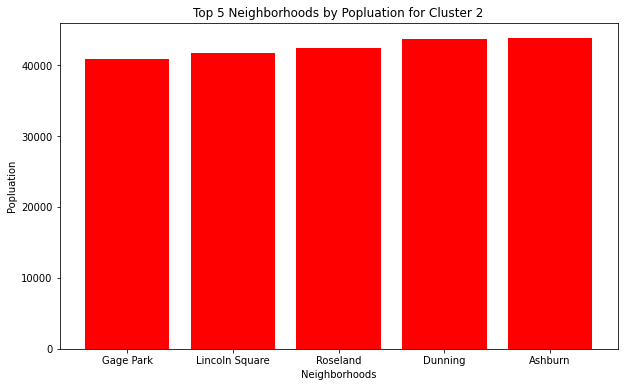

In [ ]:
top5_c2 = Cluster2.sort_values(by=['Pop.'], ascending=True,).head(5)
fig = plt.figure(figsize=(10,6))

plt.bar(top5_c2['Neighborhood'], top5_c2['Pop.'], color='red')
plt.title("Top 5 Neighborhoods by Popluation for Cluster 2")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation")
plt.show

<function matplotlib.pyplot.show>

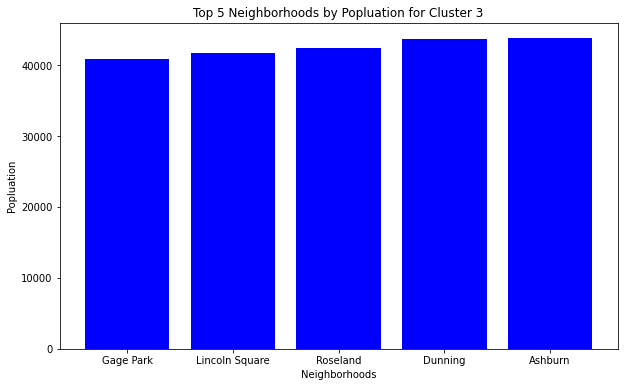

In [ ]:
top5_c3 = both_clusters.sort_values(by=['Pop.'], ascending=True,).head(5)

fig = plt.figure(figsize=(10,6))
plt.bar(top5_c3['Neighborhood'], top5_c3['Pop.'], color='blue')
plt.title("Top 5 Neighborhoods by Popluation for Cluster 3")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation")
plt.show

<function matplotlib.pyplot.show>

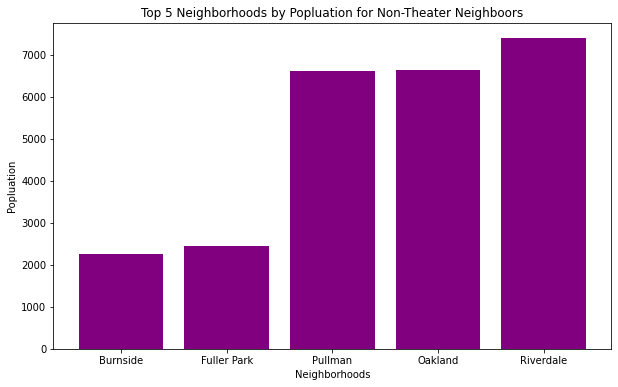

In [ ]:
top5_t = N_list.sort_values(by=['Pop.'], ascending=True,).head(5)
fig = plt.figure(figsize=(10,6))

plt.bar(top5_t['Neighborhood'], top5_t['Pop.'], color='purple')
plt.title("Top 5 Neighborhoods by Popluation for Non-Theater Neighboors")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation")
plt.show

<function matplotlib.pyplot.show>

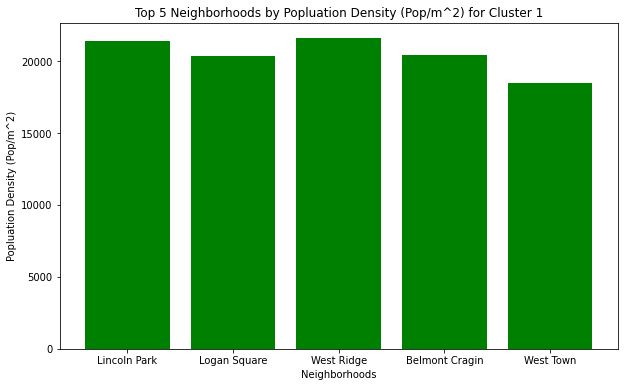

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.bar(top5_c1['Neighborhood'], top5_c1['PPSM'], color='green')
plt.title("Top 5 Neighborhoods by Popluation Density (Pop/m^2) for Cluster 1")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation Density (Pop/m^2)")
plt.show

<function matplotlib.pyplot.show>

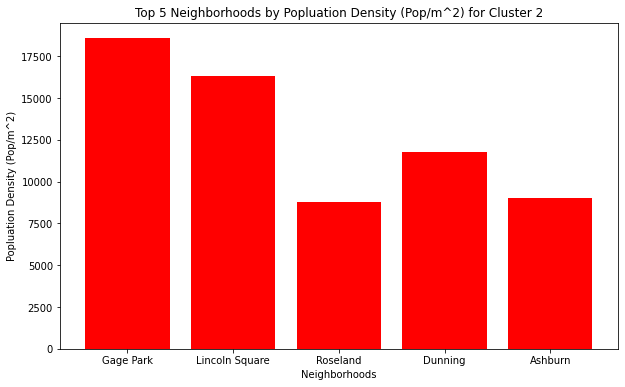

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.bar(top5_c2['Neighborhood'], top5_c2['PPSM'], color='red')
plt.title("Top 5 Neighborhoods by Popluation Density (Pop/m^2) for Cluster 2")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation Density (Pop/m^2)")
plt.show

<function matplotlib.pyplot.show>

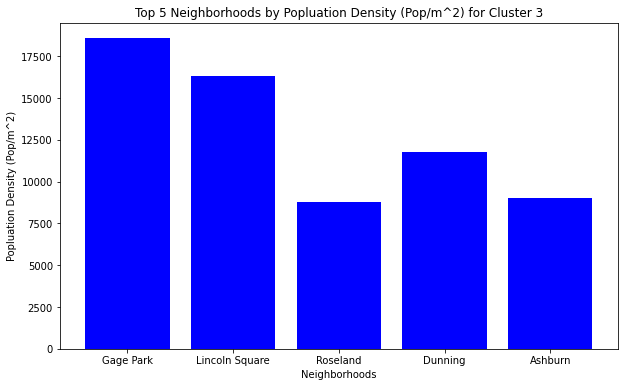

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.bar(top5_c3['Neighborhood'], top5_c3['PPSM'], color='blue')
plt.title("Top 5 Neighborhoods by Popluation Density (Pop/m^2) for Cluster 3")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation Density (Pop/m^2)")
plt.show

<function matplotlib.pyplot.show>

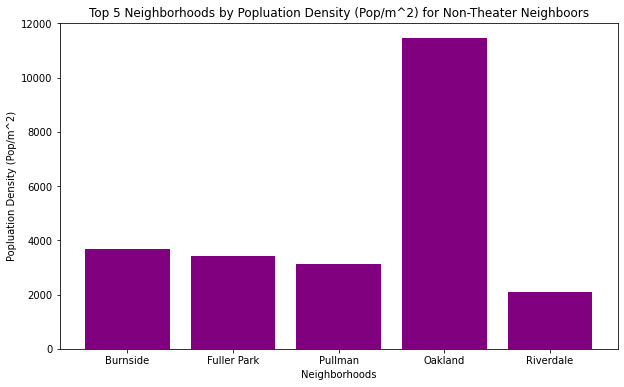

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.bar(top5_t['Neighborhood'], top5_t['PPSM'], color='purple')
plt.title("Top 5 Neighborhoods by Popluation Density (Pop/m^2) for Non-Theater Neighboors")
plt.xlabel("Neighborhoods")
plt.ylabel("Popluation Density (Pop/m^2)")
plt.show

From the visualization from the last section we can see that the DataFrame combine of the two clusters resulted in the same as cluster 2 DataFrame. This is because the weight of adding population and population density has seperated high and low for both population and population density in the clusters. Knowing this moving on the combine cluster will not be looked at.

### Rankings


In this section each of the DataFrames will be given ranks based on their population and population density, comparetively in their own DataFrame.

In [ ]:
Cluster1['Pop. Rank'] = Cluster1['Pop.'].rank(method='max')
Cluster1['PPSM Rank'] = Cluster1['PPSM'].rank(method='max')
Cluster1

,Cluster Values,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank
0,1,Albany Park,51992.0,27079.17,2.0,7.0
1,1,Chicago Lawn,53098.0,15041.93,3.0,1.0
2,1,Humboldt Park,56427.0,15674.17,5.0,2.0
3,1,Irving Park,54606.0,17011.21,4.0,4.0
4,1,Lincoln Park,67710.0,21427.22,7.0,6.0
5,1,Portage Park,64307.0,16280.25,6.0,3.0
6,1,South Shore,50418.0,17207.51,1.0,5.0


In [ ]:
Cluster2['Pop. Rank'] = Cluster2['Pop.'].rank(method='max')
Cluster2['PPSM Rank'] = Cluster2['PPSM'].rank(method='max')
Cluster2

,Cluster Values,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank
0,2,Archer Heights,13142.0,6538.31,11.0,9.0
1,2,Armour Square,13455.0,13455.00,13.0,27.0
2,2,Avalon Park,9985.0,7988.00,7.0,17.0
3,2,Beverly,20822.0,6547.80,24.0,10.0
4,2,Burnside,2254.0,3695.08,1.0,6.0
5,2,Calumet Heights,13188.0,7536.00,12.0,14.0
6,2,Douglas,20781.0,12594.55,23.0,23.0
7,2,East Garfield Park,19996.0,10360.62,22.0,19.0
8,2,East Side,23737.0,7965.44,29.0,16.0
9,2,Edison Park,11605.0,4235.40,9.0,7.0


In [ ]:
N_list['Pop. Rank'] = N_list['Pop.'].rank(method='max')
N_list['PPSM Rank'] = N_list['PPSM'].rank(method='max')
N_list

,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank
0,West Ridge,76215.0,21590.65,63.0,64.0
1,Lincoln Square,41715.0,16294.92,49.0,52.0
2,Lincoln Park,67710.0,21427.22,61.0,63.0
3,Near North Side,88893.0,32442.70,65.0,66.0
4,Edison Park,11605.0,4235.40,9.0,8.0
...,...,...,...,...,...
61,Beverly,20822.0,6547.80,25.0,11.0
62,Washington Heights,27453.0,9598.95,35.0,29.0
63,Mount Greenwood,19277.0,7113.28,22.0,13.0
64,Morgan Park,22394.0,6786.06,27.0,12.0


Here the list of the top five ranking Neighborhoods by population density are store in a final DataFrame.

In [ ]:
Cluster1_top5 = Cluster1.sort_values(by=['PPSM Rank'], ascending=True,).head(5)
Cluster2_top5 = Cluster2.sort_values(by=['PPSM Rank'], ascending=True,).head(5)
N_list_top5 = N_list.sort_values(by=['PPSM Rank'], ascending=True,).head(5)

In [ ]:
lat_lng = Neigh_lat_lng[['Name','Latitude','Longitude']]
lat_lng = lat_lng.rename(columns={"Name":'Neighborhood'})

In [ ]:
Cluster1_top5 = pd.merge(Cluster1_top5, lat_lng, how="left", on=["Neighborhood"]).dropna()
Cluster2_top5 = pd.merge(Cluster2_top5, lat_lng, how="left", on=["Neighborhood"]).dropna()
N_list_top5 = pd.merge(N_list_top5, lat_lng, how="left", on=["Neighborhood"]).dropna()

### Final list

The final lists of the highest population densities per Neighborhood of each DataFrame are displayed.

In [ ]:
Cluster1_top5

,Cluster Values,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank,Latitude,Longitude
0,1,Chicago Lawn,53098.0,15041.93,3.0,1.0,41.777057,-87.690045
1,1,Humboldt Park,56427.0,15674.17,5.0,2.0,41.903092,-87.699327
2,1,Portage Park,64307.0,16280.25,6.0,3.0,41.953976,-87.766997
3,1,Irving Park,54606.0,17011.21,4.0,4.0,41.954385,-87.736417
4,1,South Shore,50418.0,17207.51,1.0,5.0,41.761921,-87.587830


In [ ]:
map_c1 = folium.Map(location=[41.881832, -87.623177], zoom_start=11)


markers_colors = []
for lat, lon, poi in zip(Cluster1_top5['Latitude'], Cluster1_top5['Longitude'], Cluster1_top5['Neighborhood']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_c1)
       
map_c1

In [ ]:
Cluster2_top5

,Cluster Values,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank,Latitude,Longitude
0,2,O'Hare,12377.0,927.81,10.0,1.0,41.975080,-87.81630
1,2,Hegewisch,9418.0,1797.33,6.0,2.0,41.655423,-87.55365
2,2,Riverdale,7394.0,2094.62,5.0,3.0,41.660000,-87.61000
3,2,Pullman,6613.0,3119.34,3.0,4.0,41.695434,-87.62255
4,2,Fuller Park,2439.0,3435.21,2.0,5.0,41.814283,-87.65282


In [ ]:
map_c2 = folium.Map(location=[41.881832, -87.623177], zoom_start=10)


markers_colors = []
for lat, lon, poi in zip(Cluster2_top5['Latitude'], Cluster2_top5['Longitude'], Cluster2_top5['Neighborhood']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_c2)
       
map_c2

In [ ]:
N_list_top5

,Neighborhood,Pop.,PPSM,Pop. Rank,PPSM Rank,Latitude,Longitude
0,O'Hare,12377.0,927.81,10.0,1.0,41.975080,-87.816300
1,South Deering,14614.0,1340.73,15.0,2.0,41.687698,-87.554675
2,Hegewisch,9418.0,1797.33,6.0,3.0,41.655423,-87.553650
3,Riverdale,7394.0,2094.62,5.0,4.0,41.660000,-87.610000
4,Pullman,6613.0,3119.34,3.0,5.0,41.695434,-87.622550


In [ ]:
map_n = folium.Map(location=[41.881832, -87.623177], zoom_start=10)


markers_colors = []
for lat, lon, poi in zip(N_list_top5['Latitude'], N_list_top5['Longitude'], N_list_top5['Neighborhood']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7).add_to(map_n)
       
map_n

## Results and Discussion <a name="results"></a>

Looking at each of the DataFrames in the Final list section will show the neighborhoods with the highest population desnities. Each DataFrame has unique properties compare to each out. They all share one trait that each of them don't include any neighborhoods according to the data collected from FourSquare.
Cluster1_top5 is from a cluster set of neighborhoods with four theaters. This is similarly true for Cluster2_top5. N_list_top5 isn't based on any Clustering, it is just the highest population based on neighborhoods without a theater. 

These difference have values in each list. Cluster1_top5 can show the best neighborhoods based on neighborhoods that are similar to neighborhoods that already have movie theaters, but tend to have lower population and population density. Unlike Cluster2_top5 shows neighborhoods that are similar to others that have movie theater, but have a higher population and population density. Then N_list_top5 showcase the neighborhoods that have the high population density that just doesn't have a theater. 

These list can give a wide range of information depending on what is being looked for.

## Conclusion <a name="conclusion"></a>

Give all the information that is give not all the DataFrames contain information needed based on the criteria. Cluster2_top5 is the only one that meets all the goals. It is similar to neighborhoods that already have theaters, are neighborhoods that don't have movie theaters and have the highest population density per neighborhood. Using the DataFrame Cluster2_top5 the stock holders will be able to make the best decision on which neighborhood is best to open up their new movie theater.